In [71]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
shap.initjs()
%matplotlib inline
task_name = '02'

In [72]:
try:
    with open(task_name + '.dataset', 'rb') as f:
        X, y, feature_names = pickle.load(f)
    with open(task_name + '.models', 'rb') as f:
        comparer = pickle.load(f)
    with open(task_name + '.expl', 'rb') as f:
        explanations = pickle.load(f)
    print('loaded saved state')
except FileNotFoundError:
    pass

loaded saved state


# Setup Task

In [12]:
X, y = make_moons(n_samples=300, noise=0.3, random_state=0)
X *= 100
feature_names = np.array(['x1', 'x2'])
with open(task_name + '.dataset', 'wb') as f:
    pickle.dump((X, y, feature_names), f, pickle.HIGHEST_PROTOCOL)

In [30]:
from sklearn.svm import SVC
ref_model = SVC(probability=True)
ref_model.fit(X, y)

SVC(probability=True)

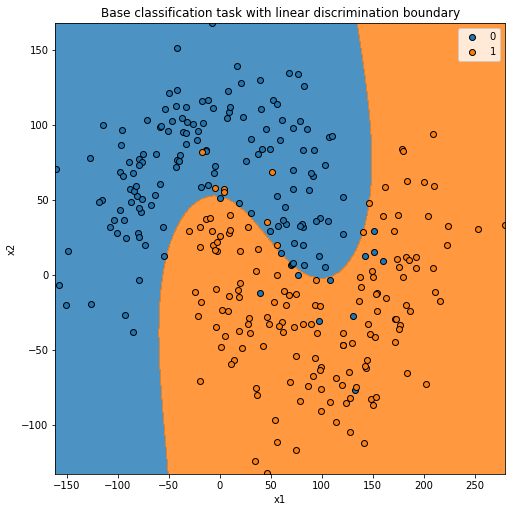

In [31]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with linear discrimination boundary', feature_names,
                       predict=ref_model.predict, class_names=ref_model.classes_,
                       fig=fig, ax=ax)

In [32]:
clf_a = ref_model

In [33]:
from sklearn.ensemble import RandomForestClassifier
clf_b = RandomForestClassifier()
clf_b.fit(X, y)

RandomForestClassifier()

In [34]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)
with open(task_name + '.models', 'wb') as f:
    cloudpickle.dump(comparer, f, pickle.HIGHEST_PROTOCOL)

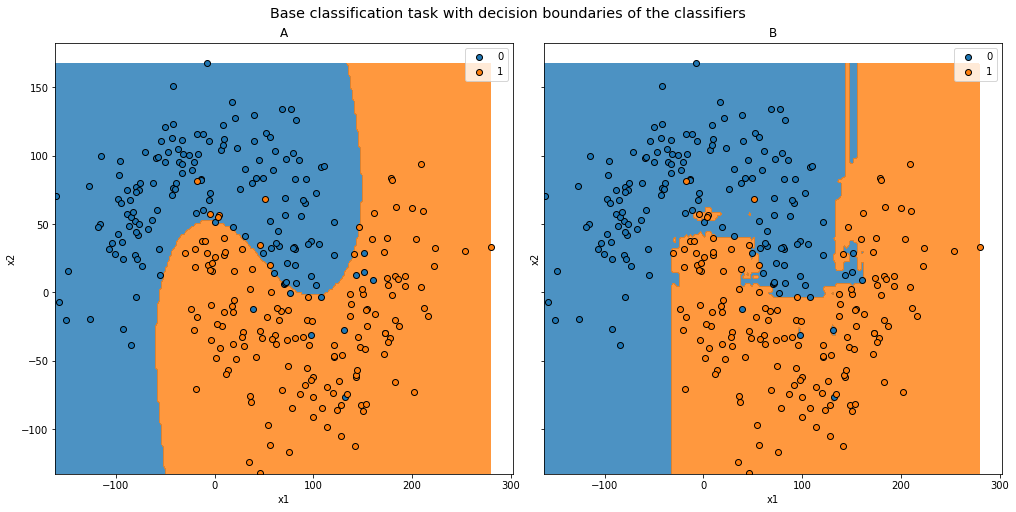

In [35]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label', mesh_step_size=2)

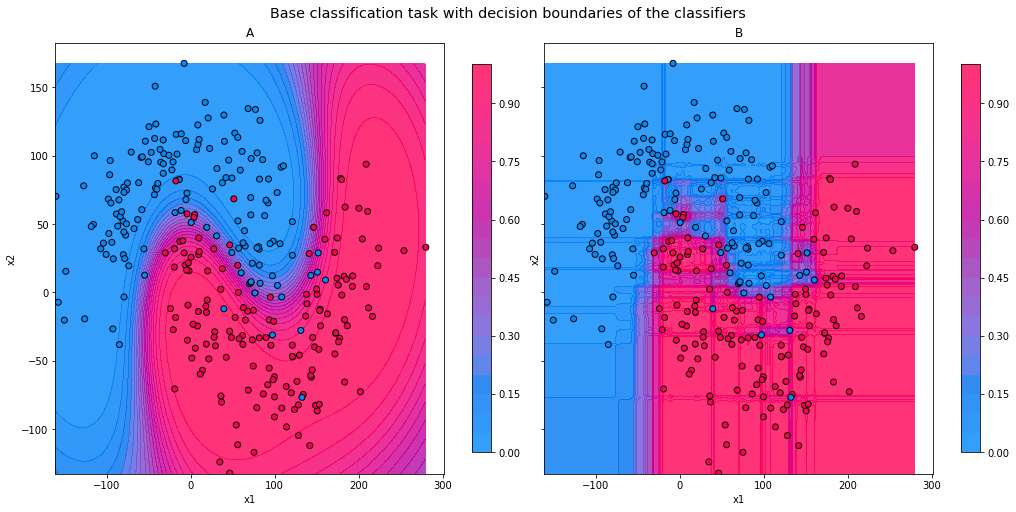

In [36]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='proba', mesh_step_size=2)

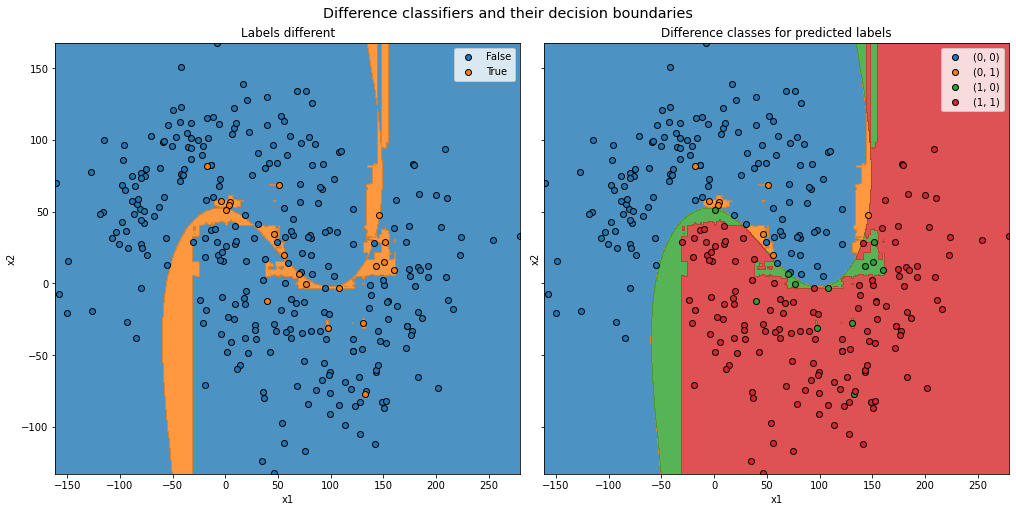

In [37]:
comparer.plot_decision_boundaries(X)

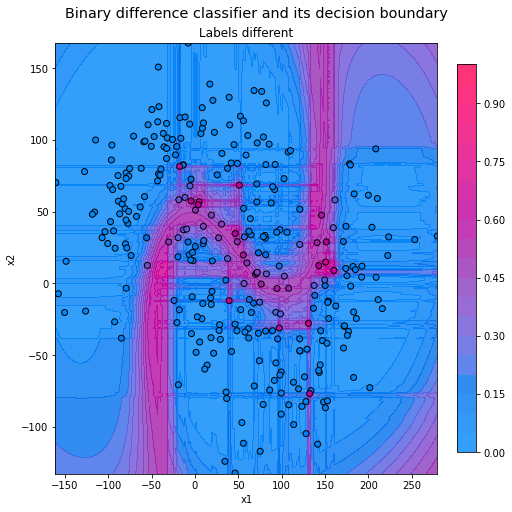

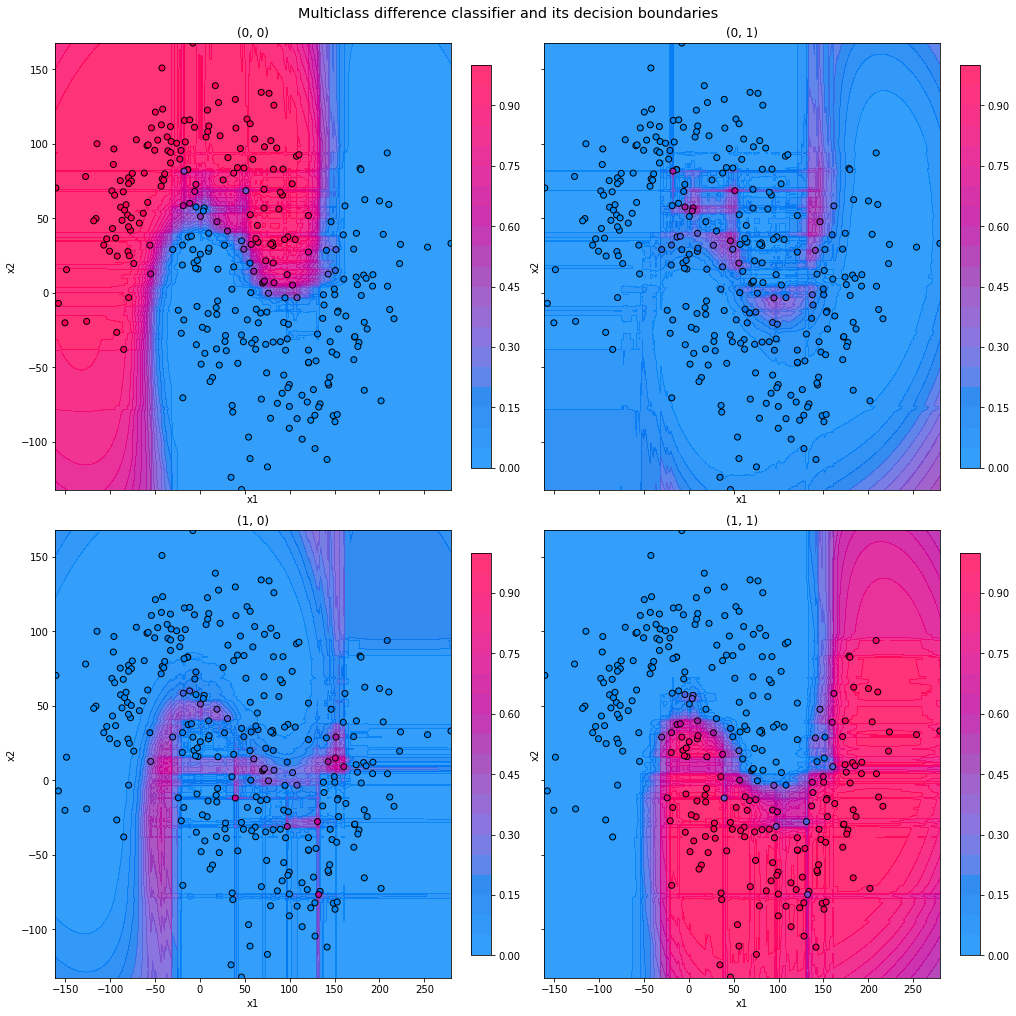

In [38]:
comparer.plot_decision_boundaries(X, kind='proba')

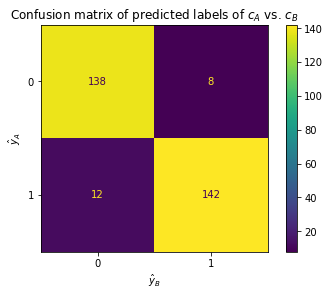

In [39]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [61]:
%%time
explanations = generate_shap_explanations(comparer, X, space_types=['labels', 'proba'])
with open(task_name + '.expl', 'wb') as f:
    pickle.dump(explanations, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 301it [00:10,  2.19it/s]                         
Exact explainer: 301it [00:11,  3.29it/s]                         
Exact explainer: 301it [00:10,  1.76it/s]                         
Exact explainer: 301it [00:11,  2.51it/s]                         

CPU times: user 1min 6s, sys: 243 ms, total: 1min 6s
Wall time: 1min 6s


## Visualize SHAP values

### Individual explanations

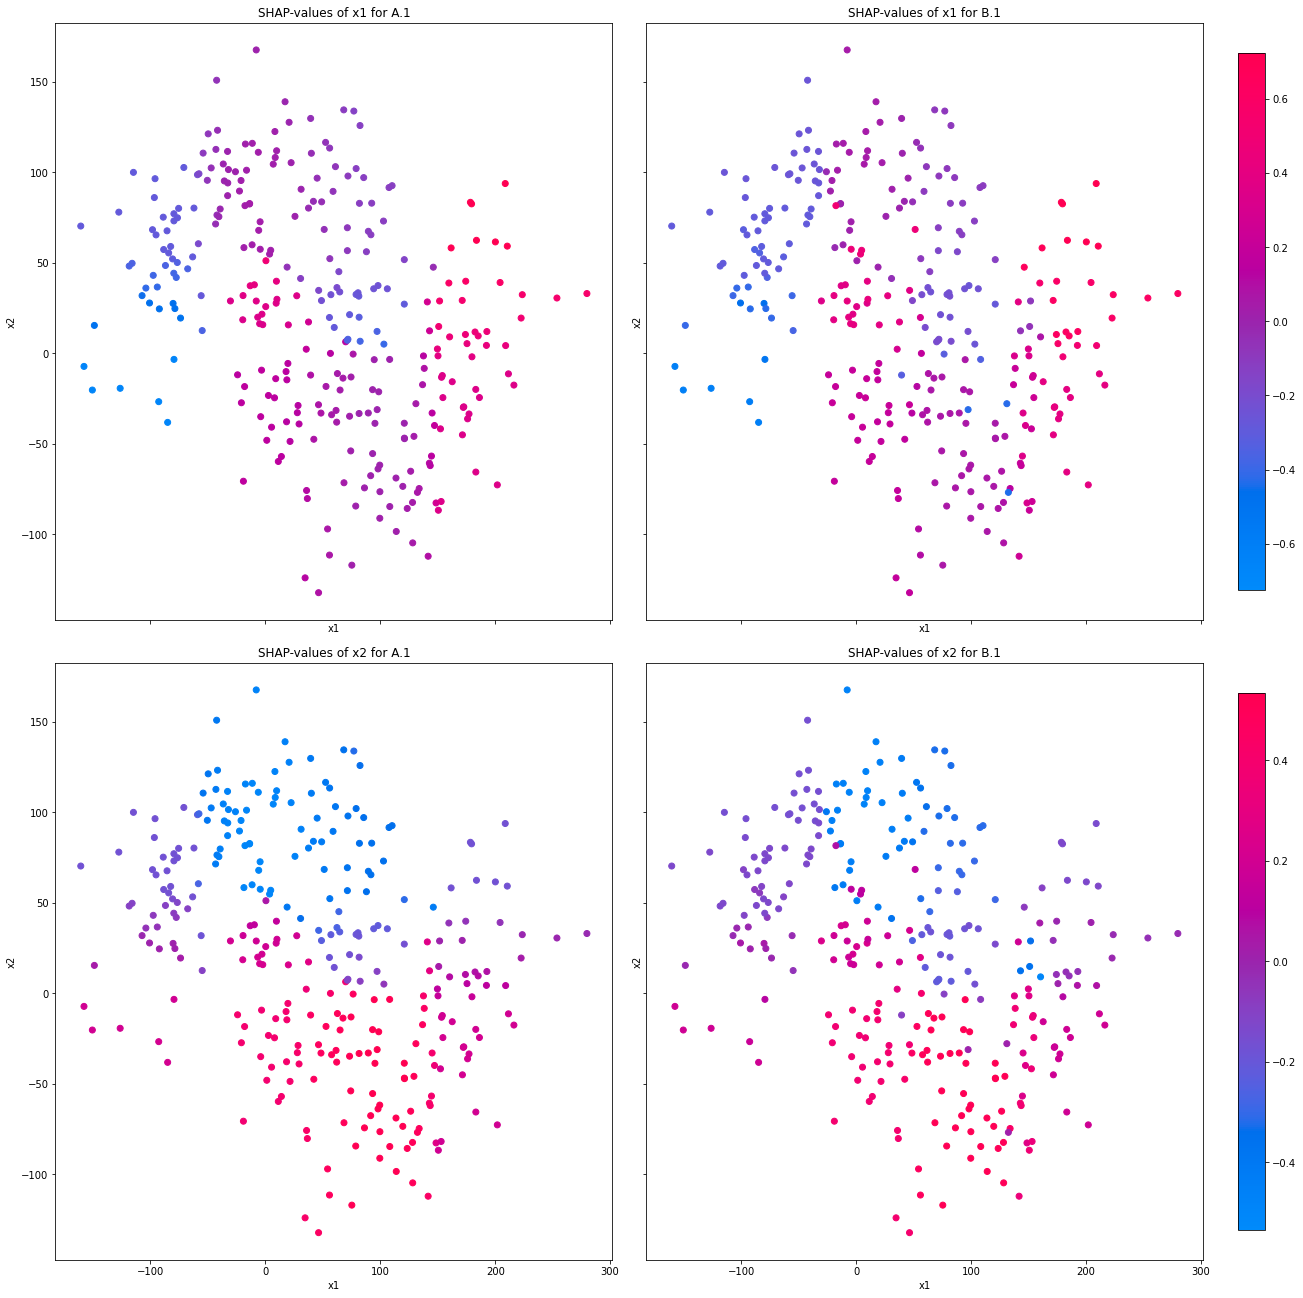

In [41]:
plot_2d(explanations.indiv.labels[:, :, 1])

### Simple subtraction explanation

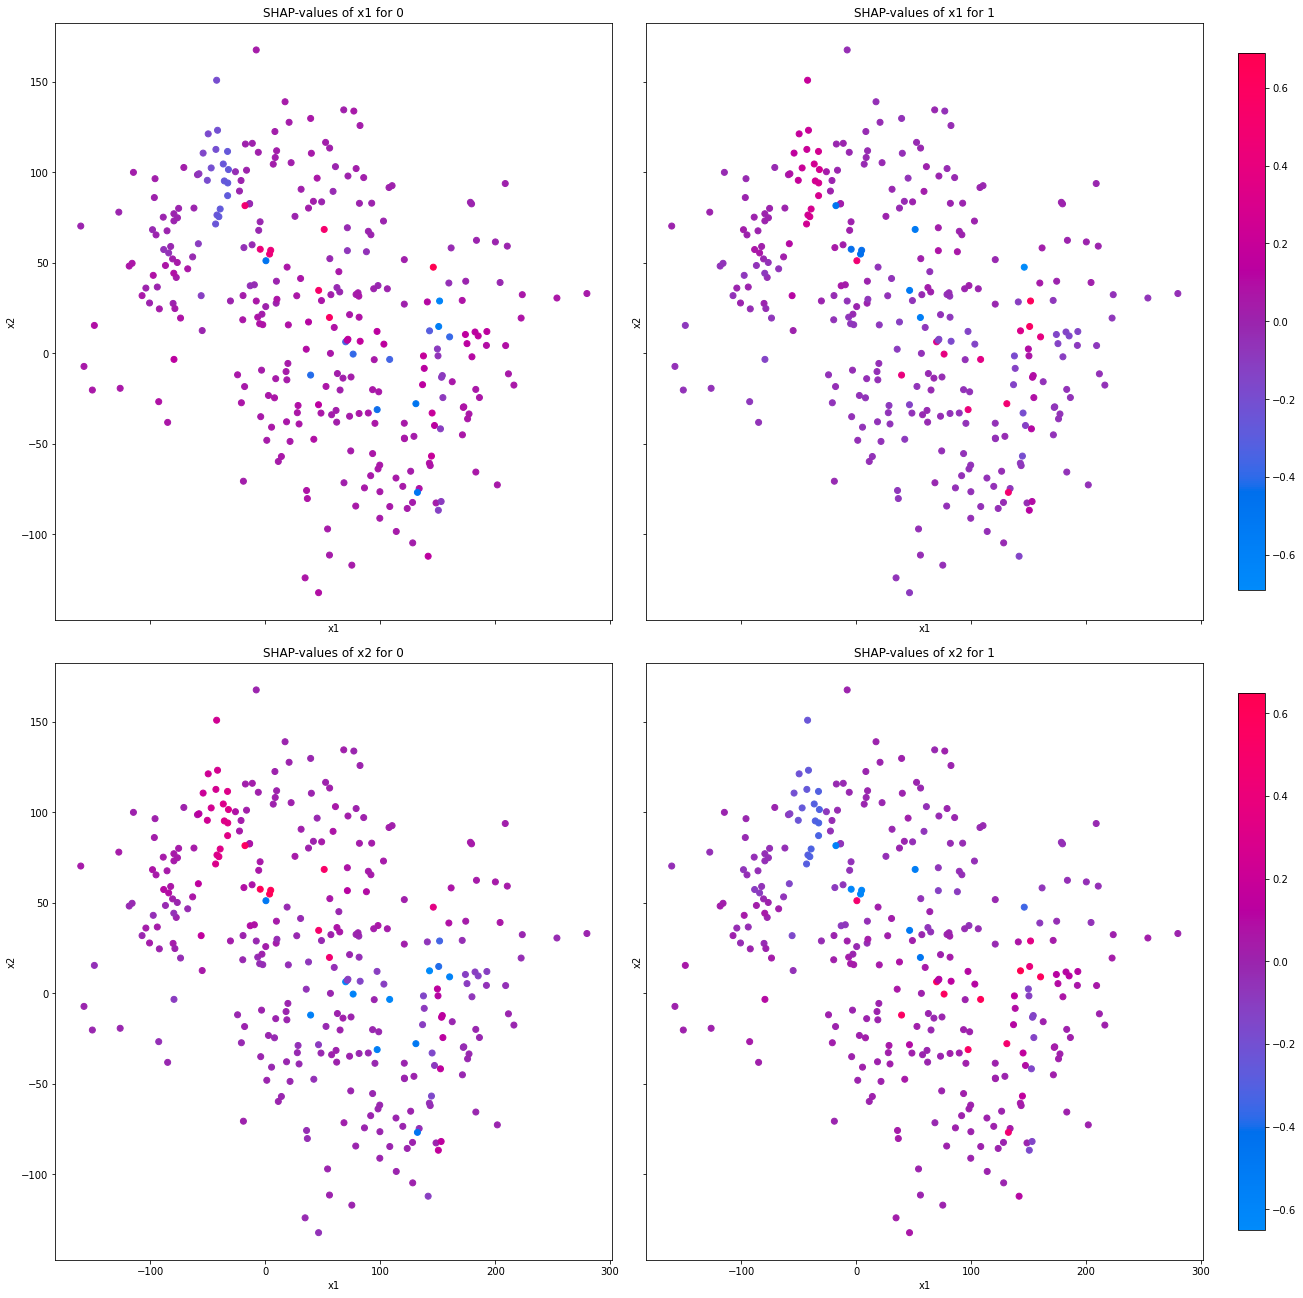

In [42]:
plot_2d(explanations.indiv_diff.labels)

### Multiclass difference classifier explanations

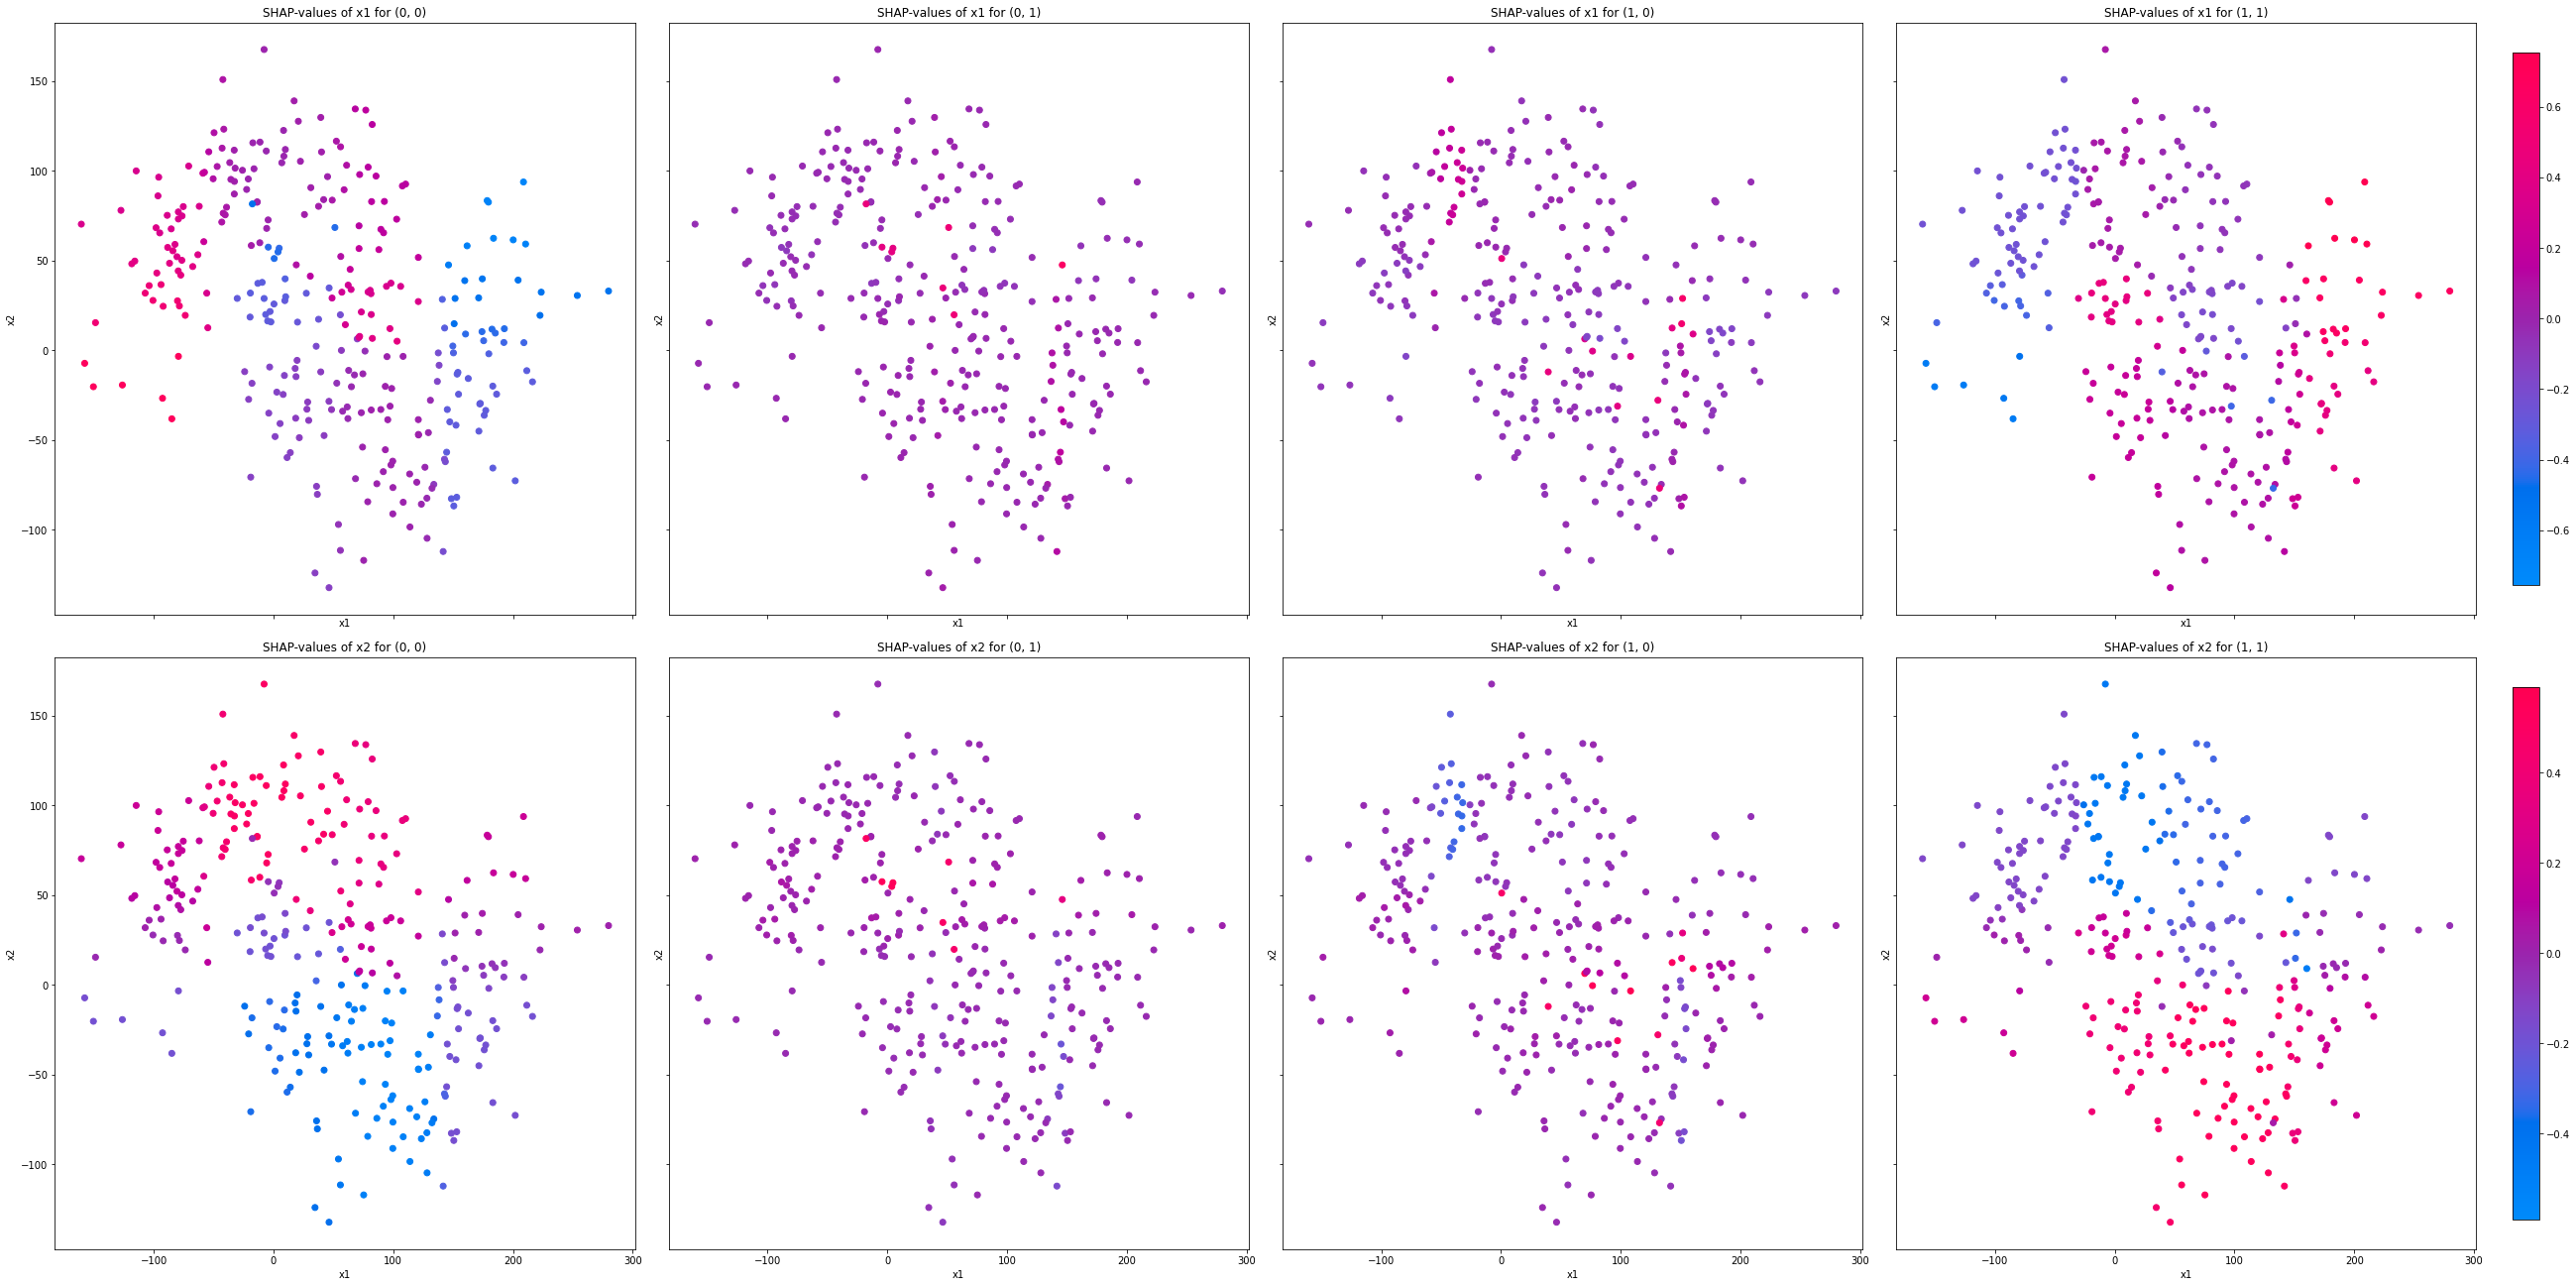

In [43]:
plot_2d(explanations.mclass_diff.labels)

## Feature importance

### Individual explanations

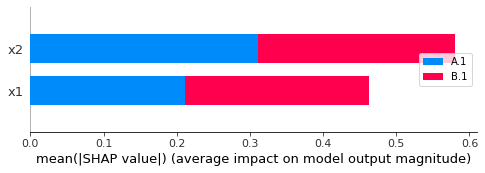

In [44]:
plot_feature_importance_bar(explanations.indiv.labels[:, :, 1])

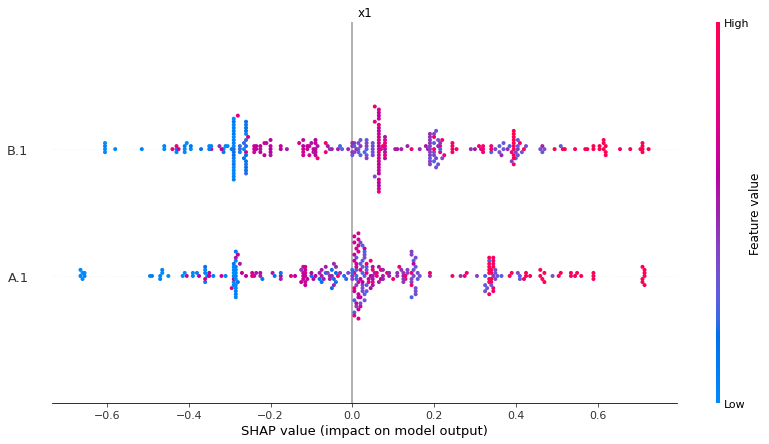

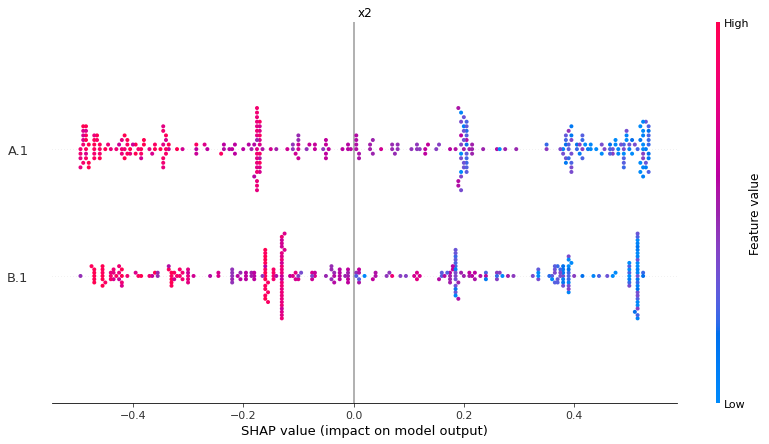

In [63]:
plot_feature_importance_scatter(explanations.indiv.labels[:, :, 1])

### Simple subtraction explanation

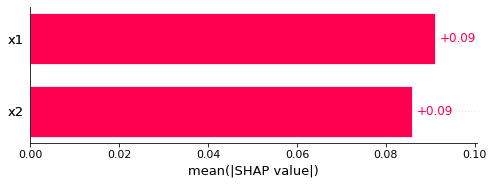

In [46]:
plot_feature_importance_bar(explanations.indiv_diff.labels[:, :, 1])

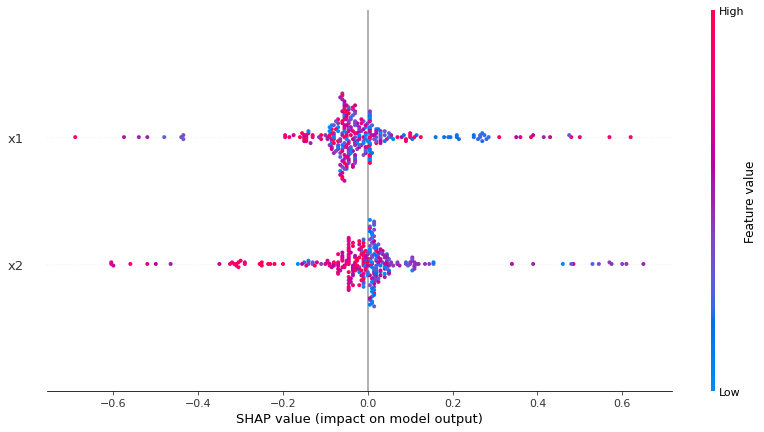

In [47]:
plot_feature_importance_scatter(explanations.indiv_diff.labels[:, :, 1])

### Multiclass difference classifier explanations

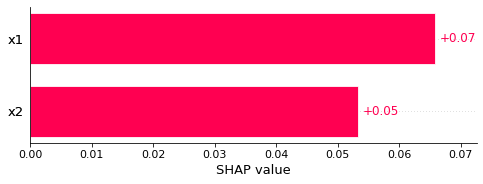

In [48]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.labels[:, :, comparer.difference_class_names])
plot_feature_importance_bar(feature_importance)

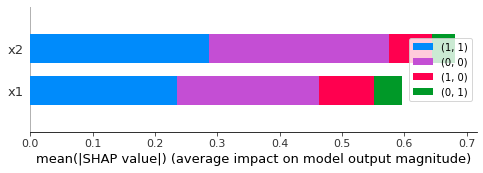

In [49]:
plot_feature_importance_bar(explanations.mclass_diff.labels)

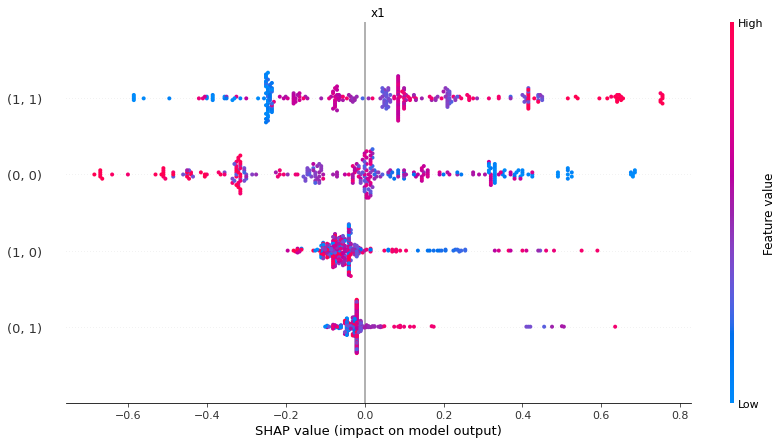

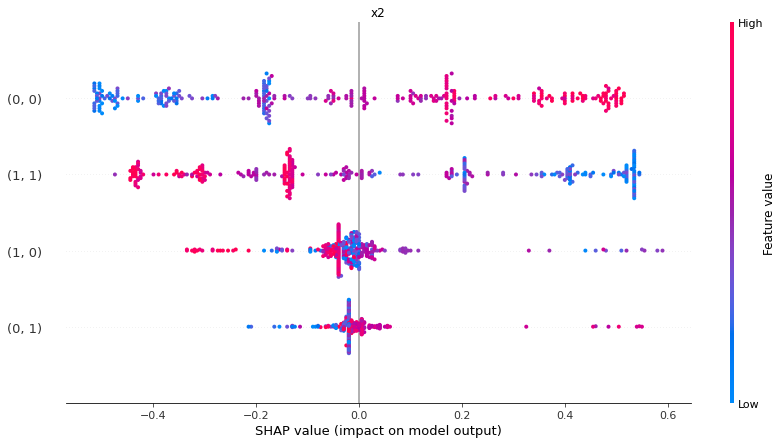

In [50]:
plot_feature_importance_scatter(explanations.mclass_diff.labels)

## Feature effects

### Individual explanations

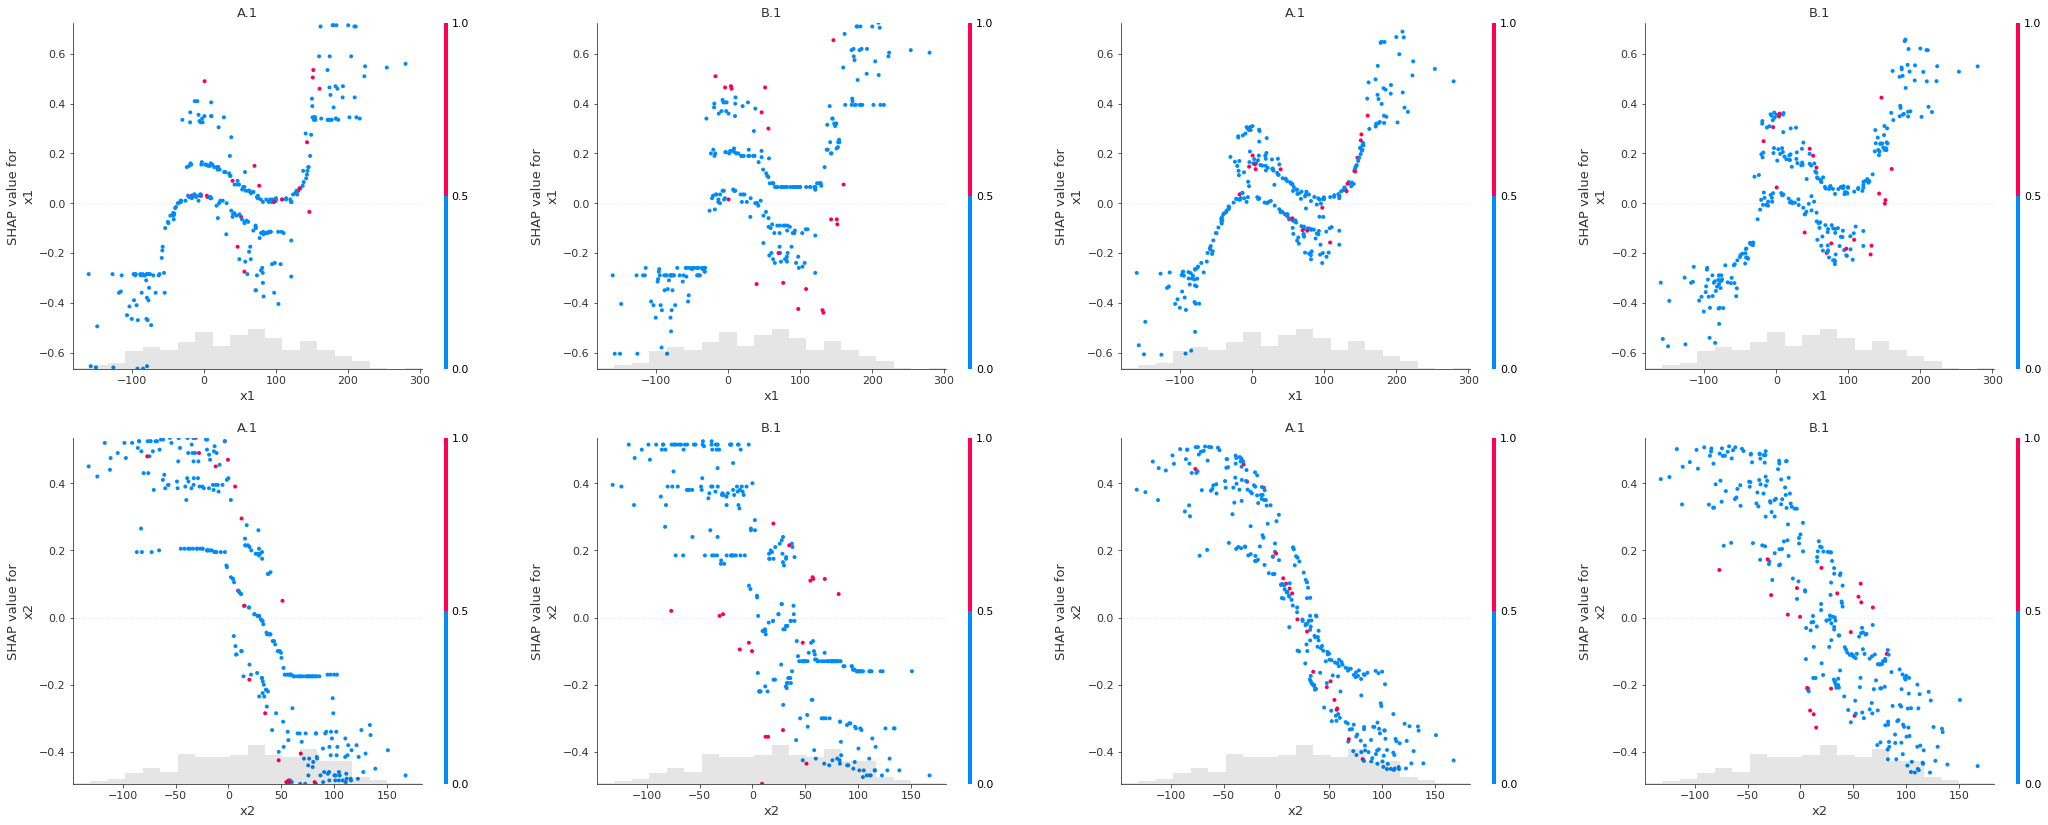

In [64]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
plot_feature_effects(explanations.indiv.labels[:, :, 1],
                     explanations.indiv.proba[:, :, 1],
                     color=is_pred_diff)

### Simple subtraction explanation

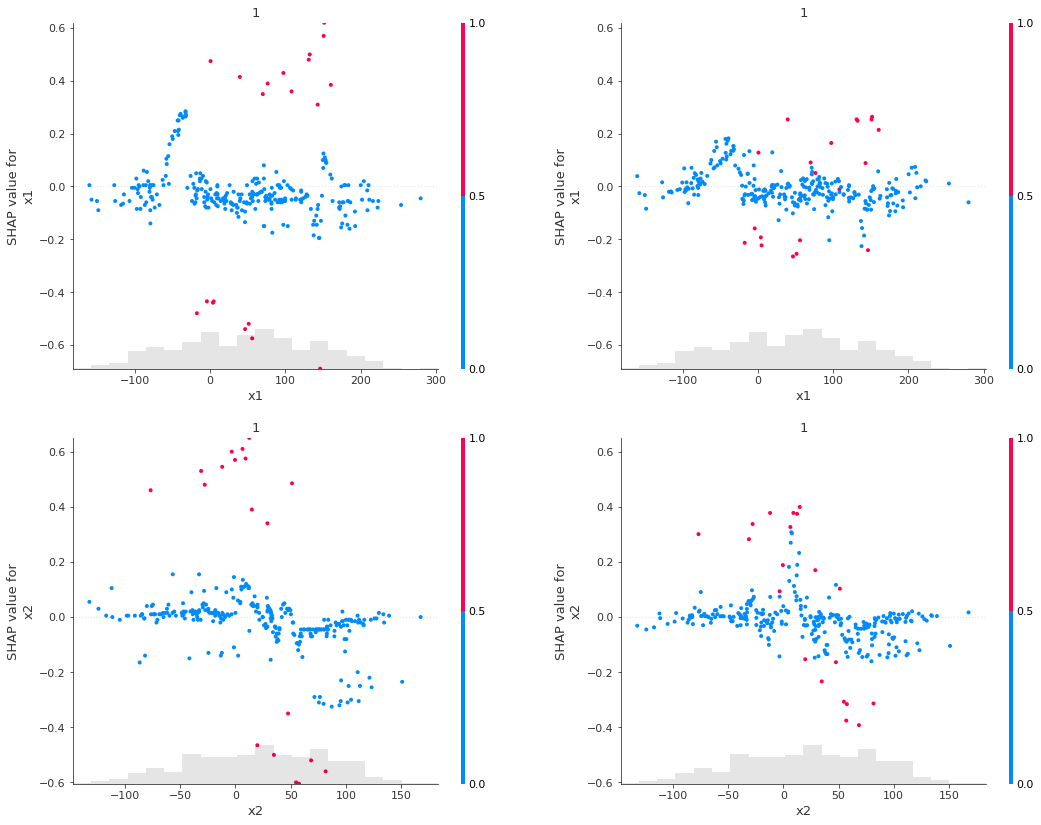

In [65]:
plot_feature_effects(explanations.indiv_diff.labels[:, :, 1],
                     explanations.indiv_diff.proba[:, :, 1],
                     color=is_pred_diff)

### Multiclass difference classifier explanations

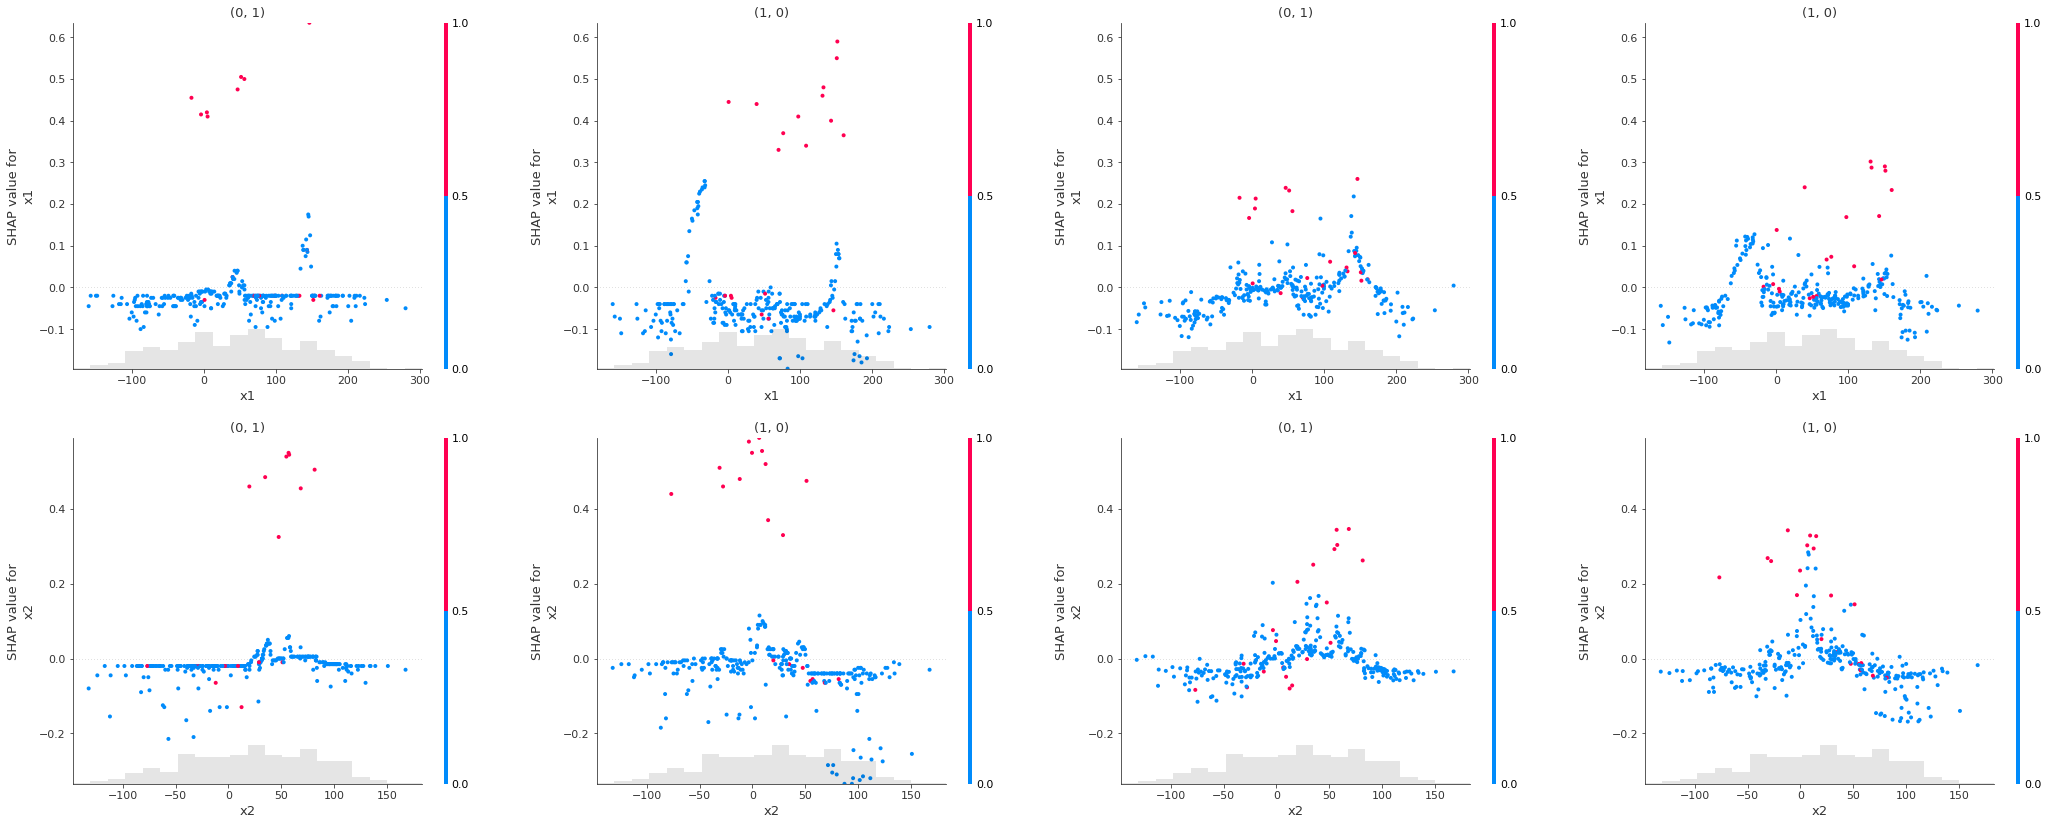

In [66]:
plot_feature_effects(explanations.mclass_diff.labels[:, :, comparer.difference_class_names],
                     explanations.mclass_diff.proba[:, :, comparer.difference_class_names],
                     color=is_pred_diff)

## Cluster instances

### Individual explanations

In [67]:
instance_order = calc_instance_order(explanations)
plot_forces(explanations.indiv.labels[:, :, 1], instance_order=instance_order)

### Simple subtraction explanation

In [68]:
plot_forces(explanations.indiv_diff.labels, instance_order=instance_order)

### Multiclass difference classifier explanations

In [69]:
plot_forces(explanations.mclass_diff.labels[:, :, comparer.difference_class_names], instance_order=instance_order)

In [70]:
plot_forces(explanations.mclass_diff.proba[:, :, comparer.difference_class_names], instance_order=instance_order)